@todo: batch effects from the 

# 0. Load data

In [88]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output
    
def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    Niter:int=100,
                    rebalance:bool=True,
                    subsample=None,
                    measurement_level_name:str='Measurement'):
    if subsample == None:
        subsample = len(df)
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        # rng = np.random.RandomState(0)
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      feature_selection.SelectFromModel(classifier()),
                                      classifier() )
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs(measurement_level_name,level=1,axis=1).astype(float)
        X[np.isinf(X)] = np.nan
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models]
    
import umap

# Suppress batch effects
def scale_by_region(df):
    scaled = []
    for region,_df in df.groupby('Region'):
        _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
        _df = pd.DataFrame(index=_df.index,columns=_df.drop(columns='Region').columns,
                           data=_X)
        _df['Region'] = region
        scaled.append(_df)
    return pd.concat(scaled)
    

In [89]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = all_df[all_df['Cell type','Meta'] == 'Basal']
basals = basals[~basals['Border','Meta'].astype(bool)]

cols2drop = [(f,'Measurement') for f in basals.droplevel(axis=1,level=1) if 'Age' in f]
cols2drop += [(f,'Measurement') for f in basals.droplevel(axis=1,level=1) if 'Time' in f]
cols2drop += [(f,'Measurement') for f in basals.droplevel(axis=1,level=1) if 'Gaussian' in f]
basals = basals.drop(columns=cols2drop)
basals.shape


(8216, 689)

### Separate measurement fields into constituent types
1. 'geom': Cell geometry
2. 'temporal': Cell rates and lookbacks
3. 'adjac': microenvironment/relative

In [92]:
all_meas

Name          Diff from Relative Cell volume at 1 frame prior  \
Metadata                                          Measurement   
Frame TrackID                                                   
0     R1_2                                                NaN   
      R1_5                                                NaN   
      R1_11                                               NaN   
      R1_19                                               NaN   
      R1_24                                               NaN   
...                                                       ...   
14    R2_1134                                       -0.042260   
      R2_1144                                       -0.905112   
      R2_1149                                        0.188145   
      R2_1155                                        0.059059   
      R2_1156                                       -0.231852   

Name          Diff from Min adjac Axial angle at 1 frame prior  \
Metadata                                           Measurement   
Frame TrackID                                                    
0     R1_2                                                 NaN   
      R1_5                                                 NaN   
      R1_11                                                NaN   
      R1_19                                                NaN   
      R1_24                                                NaN   
...                                                        ...   
14    R2_1134                                        -5.144670   
      R2_1144                                       -10.097411   
      R2_1149                                        -8.299695   
      R2_1155                                       -10.153610   
      R2_1156                                        -1.857633   

Name          Diff from Min adjac Subbasal collagen intensity at 1 frame prior  \
Metadata                                                           Measurement   
Frame TrackID                                                                    
0     R1_2                                                   NaN                 
      R1_5                                                   NaN                 
      R1_11                                                  NaN                 
      R1_19                                                  NaN                 
      R1_24                                                  NaN                 
...                                                          ...                 
14    R2_1134                                           0.022791                 
      R2_1144                                           0.006561                 
      R2_1149                                          -0.059663                 
      R2_1155                                          -0.051708                 
      R2_1156                                           0.013152                 

Name          Diff from Std adjac Mean H2B intensity at 1 frame prior  \
Metadata                                                  Measurement   
Frame TrackID                                                           
0     R1_2                                                   NaN        
      R1_5                                                   NaN        
      R1_11                                                  NaN        
      R1_19                                                  NaN        
      R1_24                                                  NaN        
...                                                          ...        
14    R2_1134                                          -0.003731        
      R2_1144                                           0.007253        
      R2_1149                                          -0.012458        
      R2_1155                                           0.002015        
      R2_1156                                          -0.016732  

In [121]:
# Filter only for geom features

meas_names = basals.xs('Measurement',level=1,axis=1).columns
meas_types = pd.DataFrame(index=meas_names)
meas_types['Type'] = 'intrinsic'
meas_types.loc[ meas_names.str.contains('curvature'),'Type' ] = 'tissue_geom'
meas_types.loc[ meas_names.str.contains('rate'),'Type' ] = 'rate'
meas_types.loc[ meas_names.str.contains('adjac'),'Type' ] = 'adjac'
meas_types.loc[ meas_names.str.contains('duration'),'Type' ] = 'duration'
meas_types.loc[ meas_names.str.contains('neighbors'),'Type' ] = 'adjac'
meas_types.loc[ meas_names.str.contains('Relative'),'Type' ] = 'relative'
meas_types.loc[ meas_names.str.contains('prior'),'Type' ] = 'temporal'

cols2keep = [(f) for f in meas_types[meas_types['Type'] == 'tissue_geom'].index]
cols2keep += [(f) for f in meas_types[meas_types['Type'] == 'adjac'].index]
cols2keep = [f for f in cols2keep if 'Manual' not in f]
metacols = [(f) for f in basals.xs('Meta',level=1,axis=1)]

all_meas = basals[cols2keep]
# all_meas = all_meas.dropna(subset=cols2keep,axis=0)
all_meas['Region'] = basals['Region']
# all_meas 

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/1674718705.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_meas['Region'] = basals['Region']
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/1674718705.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_meas['Region'] = basals['Region']


In [133]:
# Standardize

meas_scaled_by_region = scale_by_region(all_meas)
scaled_data = meas_scaled_by_region.dropna(axis=0)

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/2673402985.py:72: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/2673402985.py:73: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _df = pd.DataFrame(index=_df.index,columns=_df.drop(columns='Region').columns,
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/2673402985.py:72: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/2673402985.py:73: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact 

# 1. U-map

[https://github.com/CoAxLab/pycombat]
These input data consist of the following ingredients:

    Y: The matrix of response variables, with dimensions [observations x features]
    b: The array of batch label for each observation. In principle these could be labelled as numbers or strings.
    X: The matrix of effects of interest to keep, with dimensions [observations x features_interest]
    C: The matrix of covariates to remove, with dimensions [observations x features_covariates]


### Try a bunch of hyperparameters

In [134]:
pd.merge(scaled_data,basals['Cell cycle phase','Meta'],left_index=True,right_index=True)

Mean curvature - cell coords Mean curvature 2um  \
                               Measurement        Measurement   
Frame TrackID                                                   
0     R1_2                       -1.910376          -1.650861   
      R1_11                      -1.844331          -1.502932   
      R1_19                      -1.533235          -1.768139   
      R1_24                      -1.153661          -0.399619   
      R1_27                      -1.722477          -0.000737   
...                                    ...                ...   
14    R2_1128                     1.696276           0.216380   
      R2_1131                    -0.127542           1.011128   
      R2_1144                     4.297577          -1.098784   
      R2_1149                    -0.610560           0.798245   
      R2_1155                    -0.346322          -0.247311   

              Mean curvature 5um Mean curvature 10um Mean curvature 15um  \
                     Measurement         Measurement         Measurement   
Frame TrackID                                                              
0     R1_2             -2.581881           -3.123097           -1.729707   
      R1_11            -2.525486           -1.628263           -2.562867   
      R1_19            -1.181891           -1.193246           -1.516843   
      R1_24            -0.294712           -2.033804           -1.389635   
      R1_27            -0.374981           -0.078690           -1.345068   
...                          ...                 ...                 ...   
14    R2_1128           0.403678            1.404288            2.336817   
      R2_1131           0.901236            1.106069            0.137203   
      R2_1144          -0.649951           -1.186128           -0.961647   
      R2_1149           1.067072            1.381213            1.414333   
      R2_1155          -0.486608           -0.491309            0.282973   

              Mean adjac Nuclear volume Mean adjac Nuclear solidity  \
                            Measurement                 Measurement   
Frame TrackID                                                         
0     R1_2                    -0.925248                    0.505703   
      R1_11                   -1.282910                    0.427988   
      R1_19                   -0.889268                    0.214751   
      R1_24                   -1.481084                   -0.342005   
      R1_27                   -0.519819                   -1.213698   
...                                 ...                         ...   
14    R2_1128                 -0.173181                    0.729279   
      R2_1131                  2.294756                    1.196406   
      R2_1144                  0.507484                    1.097712   
      R2_1149                  0.344045                    1.072779   
      R2_1155                 -2.064136                   -0.177419   

              Mean adjac Nuclear height Mean adjac Cell volume  \
                            Measurement            Measurement   
Frame TrackID                                                    
0     R1_2                    -0.489661              -0.639654   
      R1_11                    0.092939              -0.339178   
      R1_19                    0.564568               0.581567   
      R1_24                    1.563311               0.255661   
      R1_27                    0.869739              -0.241629   
...                                 ...                    ...   
14    R2_1128                 -0.809384              -0.623323   
      R2_1131                 -1.421160               1.127455   
      R2_1144                 -0.469509               0.404538   
      R2_1149                 -0.333559              -0.019827   
      R2_1155                  0.482143               0.046888   

              Mean adjac Axial component  ...  \
                             Measurement  ...   
Frame TrackID       

In [135]:
from itertools import product

_mapped = pd.DataFrame(index=scaled_data.index)
_mapped['Region'] = scaled_data['Region']
_mapped['Cell state'] = pd.merge(scaled_data,basals['Cell cycle phase','Meta'],left_index=True,right_index=True)['Cell cycle phase','Meta']
_mapped.loc[basals['Birth frame','Meta'].astype(bool),'Cell state'] = 'Birth'
_mapped.loc[basals['Divide next frame','Meta'].astype(bool),'Cell state'] = 'Dividing'
_mapped.loc[basals['Will differentiate','Meta'].astype(bool),'Cell state'] = 'Differentiating'
_mapped.loc[basals['Delaminate next frame','Meta'].astype(bool),'Cell state'] = 'Delaminating'

num_neighbors2try = [5,10,25]
min_dist2try = [0.0,0.1,0.2,0.5,0.8,1]
parameters = product(num_neighbors2try,min_dist2try)
mapped = []

for num_neighbors,min_dist in tqdm(parameters):
    
    reducer = umap.UMAP(n_neighbors=num_neighbors,min_dist=min_dist)
    embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
    _this_mapped = _mapped.copy()
    
    _this_mapped['Umap1'] = embedding[:,0]
    _this_mapped['Umap2'] = embedding[:,1]
    _this_mapped['Num neighbors'] = num_neighbors
    _this_mapped['Min dist'] = min_dist

    mapped.append(_this_mapped)

mapped = pd.concat(mapped,ignore_index=True)

0it [00:00, ?it/s]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/1724255364.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
1it [00:02,  2.12s/it]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/1724255364.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
2it [00:03,  1.87s/it]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/1724255364.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
3it [00:05,  1.80s/it]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/1724255364.py:19: PerformanceWarning: dropping on a non-

In [140]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped[mapped['Num neighbors']==5],col_wrap=3,col='Min dist')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Region',alpha=0.5)
plt.legend()

TypeError: list indices must be integers or slices, not str

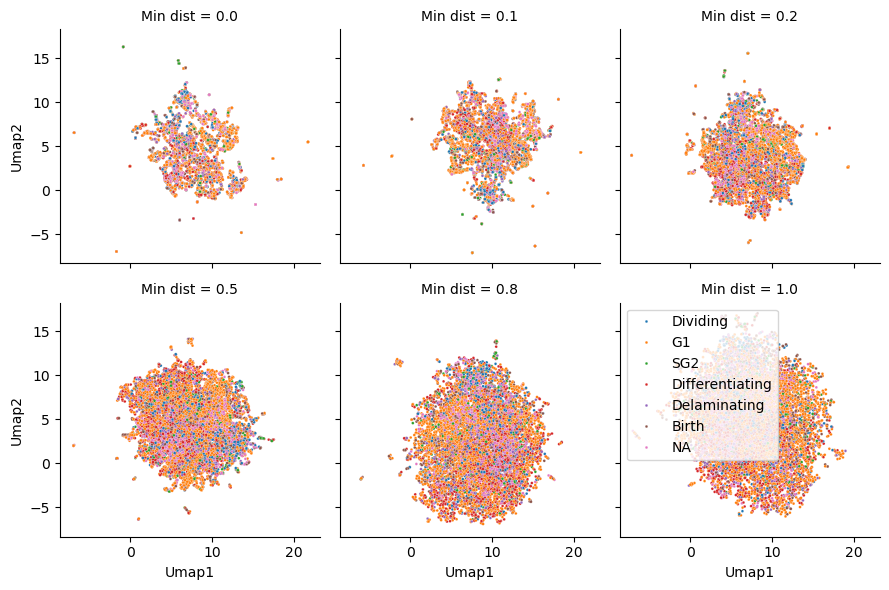

In [136]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped[mapped['Num neighbors']==5],col_wrap=3,col='Min dist')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Cell state',alpha=1)
plt.legend()

Obvious batch effects... but is it biological?

### Stability test

In [189]:
Niter = 6

_mapped = pd.DataFrame(index=scaled_data.index)
_mapped['Region'] = scaled_data['Region']
_mapped['Cell state'] = pd.merge(scaled_data,basals['Cell cycle phase','Meta'],left_index=True,right_index=True)['Cell cycle phase','Meta']

meta_cols = basals.xs('Meta',level=1,axis=1).columns
_df = pd.merge(scaled_data, basals[[(f,'Meta') for f in meta_cols]],left_index=True,right_index=True)

_mapped.loc[_df['Birth frame','Meta'].astype(bool),'Cell state'] = 'Birth'
_mapped.loc[_df['Divide next frame','Meta'].astype(bool),'Cell state'] = 'Dividing'
_mapped.loc[_df['Will differentiate','Meta'].astype(bool),'Cell state'] = 'Differentiating'
_mapped.loc[basals['Delaminate next frame','Meta'].astype(bool),'Cell state'] = 'Delaminating'

mapped = []
for i in tqdm(range(Niter)):
    
    reducer = umap.UMAP(n_neighbors=5,min_dist=1)
    embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
    _this_mapped = _mapped.copy()
    
    _this_mapped['Umap1'] = embedding[:,0]
    _this_mapped['Umap2'] = embedding[:,1]
    _this_mapped['Umap run'] = i

    mapped.append(_this_mapped)

mapped = pd.concat(mapped,ignore_index=True)

  0%|                                     | 0/6 [00:00<?, ?it/s]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/3335655017.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
 17%|████▊                        | 1/6 [00:02<00:10,  2.04s/it]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/3335655017.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
 33%|█████████▋                   | 2/6 [00:03<00:07,  1.89s/it]/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/3335655017.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  embedding = reducer.fit_transform(scaled_data.drop(columns='Region'))
 50%|████████

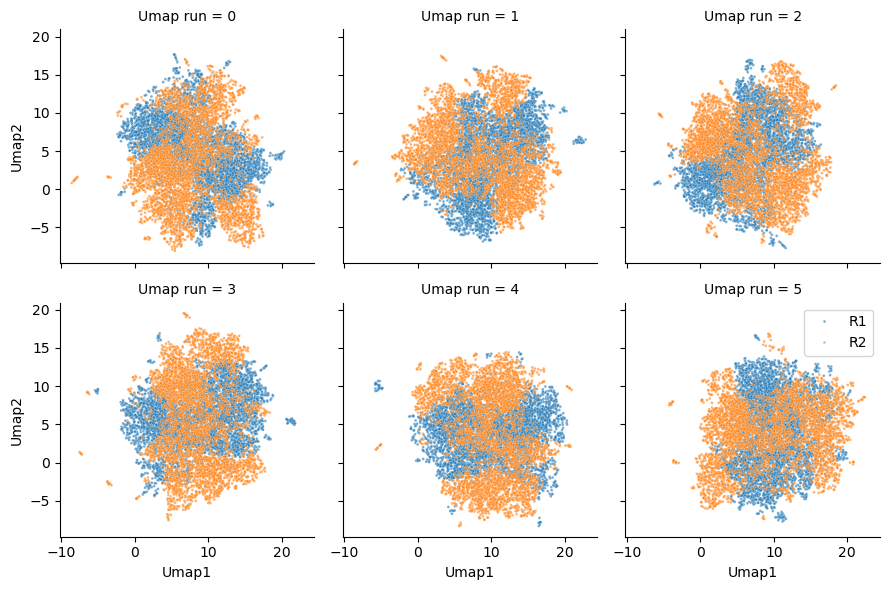

In [190]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped,col_wrap=3,col='Umap run')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Region',alpha=0.6)
plt.legend()

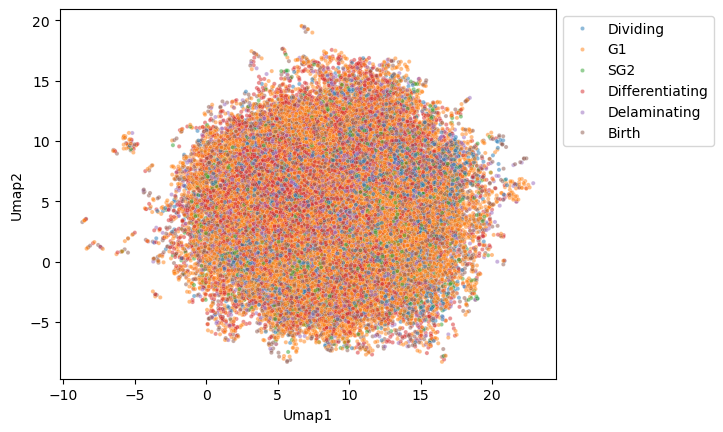

In [194]:
mpl.rcParams['lines.markersize'] = 3              # <---- set markersize here

sb.scatterplot(data=mapped[mapped['Cell state'] != 'NA'],x='Umap1',y='Umap2',
                hue='Cell state',alpha=0.5,)
               # size='Cell state',
               # size_order=['Birth','Dividing','Differentiating','SG2','G1'])
plt.legend(bbox_to_anchor=(1,1))


Basicallly, all UMAP runs returns similar graphs

## Visualize UMAPs alongside cell state annotation

In [184]:
mapped

,Region,Cell state,Umap1,Umap2,Umap run
0,R1,Dividing,13.002399,-1.645802,0
1,R1,G1,13.088058,-2.204107,0
2,R1,G1,0.098166,4.791499,0
3,R1,SG2,-0.001417,4.669090,0
4,R1,Differentiating,1.997681,3.737739,0
...,...,...,...,...,...
47581,R2,G1,8.840401,0.882071,5
47582,R2,G1,15.130612,4.319584,5
47583,R2,G1,9.784782,11.524554,5
47584,R2,G1,10.447657,3.901457,5


In [197]:
mpl.rcParams['lines.markersize'] = 5              # <---- set markersize here

_df = pd.merge(scaled_data, basals[[(f,'Meta') for f in meta_cols]],left_index=True,right_index=True)

_df['Umap1'] = embedding[:,0]
_df['Umap2'] = embedding[:,1]
_df

Name          Mean curvature - cell coords Mean curvature 2um  \
Metadata                       Measurement        Measurement   
Frame TrackID                                                   
0     R1_2                       -1.910376          -1.650861   
      R1_11                      -1.844331          -1.502932   
      R1_19                      -1.533235          -1.768139   
      R1_24                      -1.153661          -0.399619   
      R1_27                      -1.722477          -0.000737   
...                                    ...                ...   
14    R2_1128                     1.696276           0.216380   
      R2_1131                    -0.127542           1.011128   
      R2_1144                     4.297577          -1.098784   
      R2_1149                    -0.610560           0.798245   
      R2_1155                    -0.346322          -0.247311   

Name          Mean curvature 5um Mean curvature 10um Mean curvature 15um  \
Metadata             Measurement         Measurement         Measurement   
Frame TrackID                                                              
0     R1_2             -2.581881           -3.123097           -1.729707   
      R1_11            -2.525486           -1.628263           -2.562867   
      R1_19            -1.181891           -1.193246           -1.516843   
      R1_24            -0.294712           -2.033804           -1.389635   
      R1_27            -0.374981           -0.078690           -1.345068   
...                          ...                 ...                 ...   
14    R2_1128           0.403678            1.404288            2.336817   
      R2_1131           0.901236            1.106069            0.137203   
      R2_1144          -0.649951           -1.186128           -0.961647   
      R2_1149           1.067072            1.381213            1.414333   
      R2_1155          -0.486608           -0.491309            0.282973   

Name          Mean adjac Nuclear volume Mean adjac Nuclear solidity  \
Metadata                    Measurement                 Measurement   
Frame TrackID                                                         
0     R1_2                    -0.925248                    0.505703   
      R1_11                   -1.282910                    0.427988   
      R1_19                   -0.889268                    0.214751   
      R1_24                   -1.481084                   -0.342005   
      R1_27                   -0.519819                   -1.213698   
...                                 ...                         ...   
14    R2_1128                 -0.173181                    0.729279   
      R2_1131                  2.294756                    1.196406   
      R2_1144                  0.507484                    1.097712   
      R2_1149                  0.344045                    1.072779   
      R2_1155                 -2.064136                   -0.177419   

Name          Mean adjac Nuclear height Mean adjac Cell volume  \
Metadata                    Measurement            Measurement   
Frame TrackID                                                    
0     R1_2                    -0.489661              -0.639654   
      R1_11                    0.092939              -0.339178   
      R1_19                    0.564568               0.581567   
      R1_24                    1.563311               0.255661   
      R1_27                    0.869739              -0.241629   
...                                 ...                    ...   
14    R2_1128                 -0.809384              -0.623323   
      R2_1131                 -1.421160               1.127455   
      R2_1144                 -0.469509               0.404538   
      R2_1149                 -0.333559              -0.019827   
      R2_1155                  0.482143               0.046888   

Name          Mean adjac Axial component  ... Divide next frame  \
Metadata                     Measurem

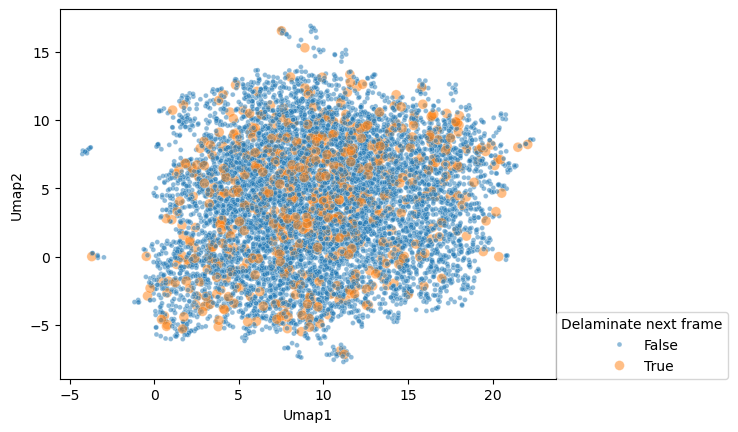

In [198]:
ax = sb.scatterplot( _df.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Delaminate next frame',alpha=0.5,
              size='Delaminate next frame', size_order=[True,False])
sb.move_legend(ax,[1,0])

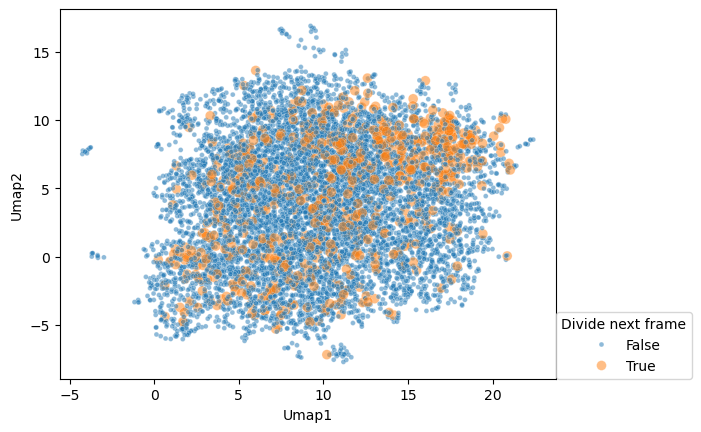

In [199]:
ax = sb.scatterplot( _df.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Divide next frame',alpha=0.5,
              size='Divide next frame', size_order=[True,False])
sb.move_legend(ax,[1,0])

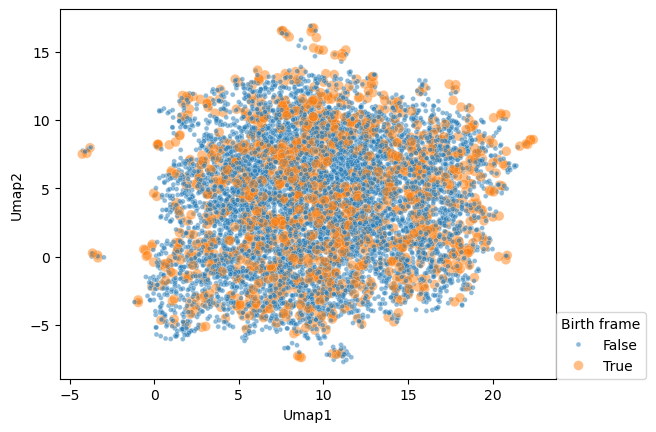

In [200]:
ax = sb.scatterplot( _df.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Birth frame',alpha=0.5,
              size='Birth frame', size_order=[True,False])
sb.move_legend(ax,[1,0])

# PCA

In [338]:
scaled_data

Name          Mean curvature - cell coords Mean curvature 2um  \
Metadata                       Measurement        Measurement   
Frame TrackID                                                   
0     R1_11                      -1.844331          -1.502932   
      R1_27                      -1.722477          -0.000737   
      R1_31                      -2.225832          -3.091147   
      R1_60                      -1.215089          -0.705813   
      R1_64                      -1.531884          -0.590960   
...                                    ...                ...   
14    R2_1087                     1.829391          -1.100059   
      R2_1098                     0.286426          -3.742375   
      R2_1099                     0.156784          -1.954646   
      R2_1128                     1.696276           0.216380   
      R2_1149                    -0.610560           0.798245   

Name          Mean curvature 5um Mean curvature 10um Mean curvature 15um  \
Metadata             Measurement         Measurement         Measurement   
Frame TrackID                                                              
0     R1_11            -2.525486           -1.628263           -2.562867   
      R1_27            -0.374981           -0.078690           -1.345068   
      R1_31            -1.349771           -0.556496           -0.345769   
      R1_60            -1.423619           -1.263668           -2.788053   
      R1_64            -1.226162            0.375560            0.499668   
...                          ...                 ...                 ...   
14    R2_1087           1.485457            0.031704           -1.015376   
      R2_1098          -2.794288           -3.756064           -1.746650   
      R2_1099          -2.820352           -2.951259           -1.408292   
      R2_1128           0.403678            1.404288            2.336817   
      R2_1149           1.067072            1.381213            1.414333   

Name          Relative Nuclear volume Relative Nuclear solidity  \
Metadata                  Measurement               Measurement   
Frame TrackID                                                     
0     R1_11                 -0.783746                 -0.606513   
      R1_27                  1.137817                  0.711436   
      R1_31                 -0.525358                  1.393029   
      R1_60                 -1.131116                  1.393536   
      R1_64                  0.800815                  0.975306   
...                               ...                       ...   
14    R2_1087               -0.254640                 -1.883197   
      R2_1098                0.339242                  0.730805   
      R2_1099               -0.224090                  0.303218   
      R2_1128                1.146399                 -0.596843   
      R2_1149               -1.130827                 -0.645505   

Name          Relative Nuclear height Relative Cell volume  \
Metadata                  Measurement          Measurement   
Frame TrackID                                                
0     R1_11                 -0.664938             0.128949   
      R1_27                  3.611325            -0.116114   
      R1_31                 -0.207639             0.086784   
      R1_60                 -1.663365            -0.673299   
      R1_64                  0.088618             1.081055   
...                               ...                  ...   
14    R2_1087                1.302832            -0.417434   
      R2_1098                0.832094             1.013662   
      R2_1099                0.069238             0.367191   
      R2_1128                0.138427            -0.199650   
      R2_1149               -1.108054            -0.498735   

Name          Relative Axial component  ... Relative nuc_shcoeff_PC6  \
Metadata                   Measurement  ...              Measurement   
Frame TrackID                           ...                            


In [390]:
# Filter only for geom features

meas_names = basals.xs('Measurement',level=1,axis=1).columns
meas_types = pd.DataFrame(index=meas_names)
meas_types['Type'] = 'intrinsic'
meas_types.loc[ meas_names.str.contains('curvature'),'Type' ] = 'tissue_geom'
meas_types.loc[ meas_names.str.contains('rate'),'Type' ] = 'rate'
meas_types.loc[ meas_names.str.contains('adjac'),'Type' ] = 'adjac'
meas_types.loc[ meas_names.str.contains('duration'),'Type' ] = 'duration'
meas_types.loc[ meas_names.str.contains('neighbors'),'Type' ] = 'adjac'
meas_types.loc[ meas_names.str.contains('Relative'),'Type' ] = 'relative'
meas_types.loc[ meas_names.str.contains('prior'),'Type' ] = 'temporal'

cols2keep = [(f) for f in meas_types[meas_types['Type'] == 'tissue_geom'].index]
cols2keep += [(f) for f in meas_types[meas_types['Type'] == 'relative'].index]
cols2keep += [(f) for f in meas_types[meas_types['Type'] == 'adjac'].index]
cols2keep = [f for f in cols2keep if 'Manual' not in f]
metacols = [(f) for f in basals.xs('Meta',level=1,axis=1)]

all_meas = basals[cols2keep]
all_meas['Region'] = basals['Region']

# Standardize
meas_scaled_by_region = scale_by_region(all_meas)
scaled_data = meas_scaled_by_region.dropna(axis=0)


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/2416246442.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_meas['Region'] = basals['Region']
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/2416246442.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_meas['Region'] = basals['Region']
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/2673402985.py:72: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performan

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_20929/466437022.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_ = preprocessing.StandardScaler().fit_transform(scaled_data.drop(columns='Region'))


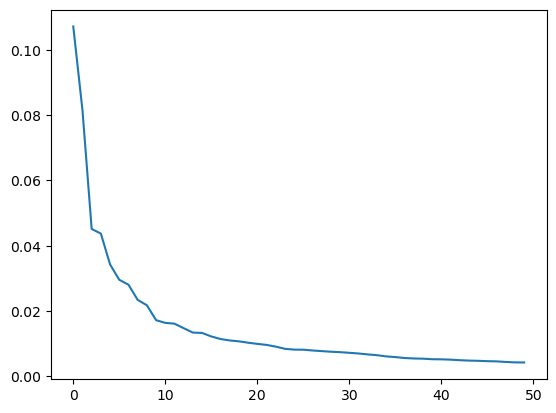

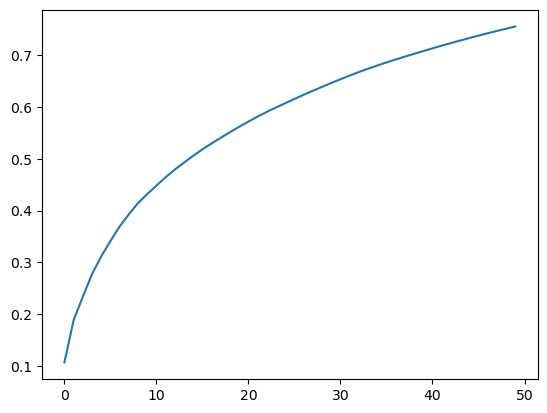

In [393]:
from sklearn import decomposition, preprocessing

N = 50

pca = decomposition.PCA(n_components=N)
X_ = preprocessing.StandardScaler().fit_transform(scaled_data.drop(columns='Region'))
X_ = pca.fit_transform(X_)
X_ = pd.DataFrame(X_,index=scaled_data.index, columns = [f'PC{i}' for i in range (N)])
X_

plt.plot(pca.explained_variance_ratio_)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

components = pca.components_
components = pd.DataFrame(components,index=[f'PC{i}' for i in range (N)],columns=scaled_data.droplevel(axis=1,level=1).columns.drop('Region')).T


In [395]:
components['PC0'].sort_values()

Name
Mean adjac Nuclear height               -0.086219
Median adjac Nuclear height             -0.075964
Min adjac Nuclear height                -0.065481
Max adjac Nuclear height                -0.064802
Relative Total H2B intensity            -0.053130
                                           ...   
Median adjac Cell volume                 0.149907
Mean adjac Total H2B intensity           0.154611
Mean adjac nuc_shcoeff_PC0               0.161332
Mean adjac cyto_shcoeffs_surface_area    0.164956
Mean adjac Cell volume                   0.166007
Name: PC0, Length: 306, dtype: float64

In [397]:
_df = pd.merge(X_,basals.droplevel(axis=1,level=1)[meta_cols],left_index=True,right_index=True)

_df = _df[_df['Fate known']]

diffs = pd.Series({i:np.diff(_df.groupby('Will divide')[f'PC{i}'].mean())[0] for i in range(N)})
diffs.abs().sort_values()


14    0.002076
49    0.010646
45    0.016846
20    0.024106
21    0.025448
30    0.026179
6     0.036219
47    0.042805
22    0.044262
43    0.046352
35    0.048441
1     0.053395
25    0.072683
40    0.081051
32    0.089543
44    0.100137
29    0.100645
41    0.101080
17    0.118744
26    0.118850
38    0.118861
31    0.124675
39    0.125814
48    0.134245
23    0.146961
37    0.148609
28    0.152640
46    0.153086
36    0.166693
33    0.184507
34    0.189801
2     0.198727
42    0.200330
0     0.203770
27    0.222372
9     0.266918
15    0.294038
18    0.348723
12    0.355790
16    0.368229
19    0.377386
4     0.416012
13    0.513921
24    0.514555
7     0.692155
10    0.755974
3     0.828181
11    1.085233
8     1.293660
5     1.598951
dtype: float64

In [403]:
i = 3

print(_df.groupby('Will divide')[f'PC{i}'].mean())
components[f'PC{i}'].sort_values()


Will divide
False    0.451751
True    -0.376430
Name: PC3, dtype: float64


Name
Std adjac cyto_shcoeffs_surface_area   -0.150517
Std adjac Cell volume standard         -0.149138
Std adjac Cell volume                  -0.145212
Std adjac nuc_shcoeff_PC0              -0.141122
Std adjac Total H2B intensity          -0.124044
                                          ...   
Min adjac Mean H2B intensity            0.148540
Mean adjac Mean H2B intensity           0.150027
Min adjac Nuclear volume standard       0.153201
Min adjac Nuclear volume                0.154095
Min adjac NC ratio                      0.166584
Name: PC3, Length: 306, dtype: float64

In [401]:
components.loc['Mean curvature 5um'].abs().sort_values()

PC5     0.001558
PC38    0.001721
PC33    0.003382
PC15    0.003512
PC14    0.005486
PC48    0.005554
PC6     0.005819
PC32    0.007104
PC29    0.007120
PC17    0.007197
PC10    0.009268
PC47    0.009638
PC45    0.015482
PC18    0.015909
PC26    0.016898
PC40    0.017338
PC3     0.019275
PC39    0.019509
PC21    0.020514
PC44    0.021447
PC25    0.021692
PC46    0.022928
PC28    0.023401
PC0     0.026087
PC49    0.027447
PC43    0.028479
PC30    0.030175
PC19    0.032106
PC37    0.032215
PC20    0.032498
PC13    0.034122
PC22    0.035680
PC35    0.037381
PC41    0.039640
PC9     0.042921
PC12    0.043420
PC31    0.047031
PC34    0.054233
PC4     0.062591
PC42    0.066357
PC16    0.067295
PC27    0.067856
PC7     0.076024
PC11    0.076812
PC2     0.080735
PC24    0.087392
PC23    0.089961
PC8     0.096260
PC1     0.100364
PC36    0.129249
Name: Mean curvature 5um, dtype: float64

In [404]:
from scipy import stats

stats.spearmanr(diffs.abs().sort_values().index,components.loc['Mean curvature 5um'].abs().values.argsort())

SignificanceResult(statistic=np.float64(0.16619447779111643), pvalue=np.float64(0.24870835467986044))